# Project 5c-SIR models

A classic epidemiological model is called the SIR model, which stands for Susceptible-Infected-Recovered (or more broadly Removed, if the disease is potentially fatal).  As the name implies, this is a population model with three populations.  The equations are pretty simple (even simpler than zombies):
$$
\frac{\partial S}{\partial t} = -\beta S I
$$
$$
\frac{\partial I}{\partial t} = \beta S I - \gamma I
$$
$$
\frac{\partial R}{\partial t} = \gamma I,
$$
yet they have rather successfully been used to model a broad array of epidemics, including, in a practical sense, COVID-19.  Implement the above equations and explore their behavior for a few combinations of parameters and initial conditions.  What are the stable states?  Does this model exhibit periodicity?

### Comparison to observations

While it is useful to examine the qualitative evolution of these systems, they are not necessarily useful for modelling real epidemics because it is not clear what the values of the parameters ought to be.  In order to do that, they need to be tuned so as to reproduce a set of real observations.  I have provided for you code to read in and process data from the first year of the pandemic in Montana.  


Text(0.5, 0, 'Days')

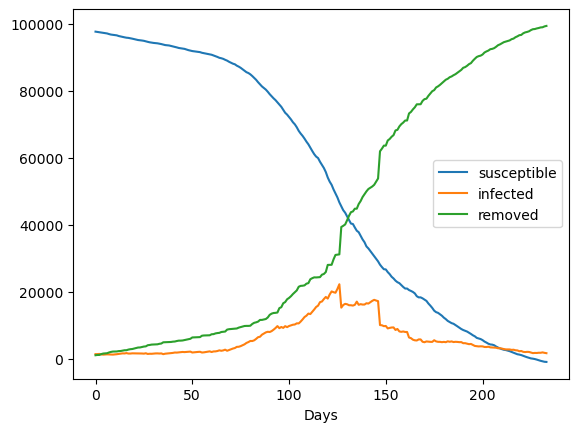

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('data/ef7e2f14.csv')

N = 1.0e5 # Initial susceptible population, here taken to be approximately 1/10 of the actual population of the state
          # or around the same amount of people that end up getting infected
removed = data['recovered'] + data['deaths']
infected = data['confirmed'] - removed
susceptible = N - infected - removed

removed = removed[removed.notnull()].to_numpy()[100:]
infected = infected[infected.notnull()].to_numpy()[100:]
susceptible = susceptible[susceptible.notnull()].to_numpy()[100:]
times = np.linspace(0,len(susceptible)-1,len(susceptible))

timesplot = times
removedplot = removed
infectedplot = infected
susceptibleplot = susceptible
# normalize
removedplot = removed/N
infectedplot = infected/N
susceptibleplot = susceptible/N


plt.plot(times,susceptible,label='susceptible')
plt.plot(times,infected,label='infected')
plt.plot(times,removed,label='removed')
plt.legend()
plt.xlabel('Days')

Try to find coefficients $\beta$ and $\gamma$ and initial conditions such that your model approximately matches this data.

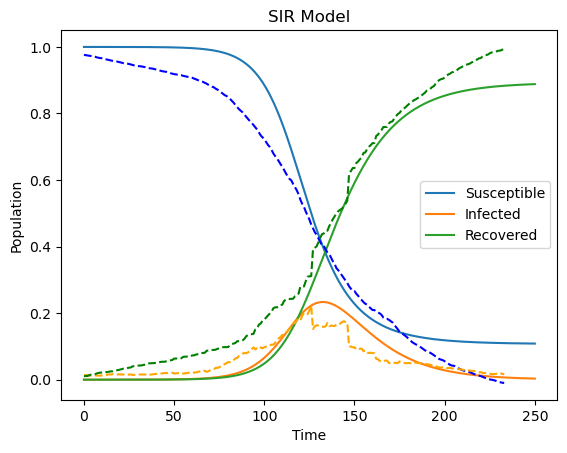

In [50]:
# Project 5d-SIR models
class SIR:
    def __init__(self, beta=0.3, gamma=0.1, num_susceptible=99999, num_infected=1, num_recovered=0):
        self.total_population = num_susceptible + num_infected + num_recovered
        self.state = np.array([num_susceptible/self.total_population, num_infected/self.total_population, num_recovered/self.total_population], dtype=float)
        # non normalized
        # self.state = np.array([num_susceptible, num_infected, num_recovered], dtype=float)
        self.beta = beta
        self.gamma = gamma

    def rhs(self, u):
        # RHS of the ODE
        susceptible, infected, recovered = u
        dsdt = -self.beta * susceptible * infected
        didt = self.beta * susceptible * infected - self.gamma * infected
        drdt = self.gamma * infected
        return np.array([dsdt, didt, drdt])
    
class Heun:
    def step(self, model, dt, state):
        # Heun's method
        k1 = model.rhs(state)
        state += dt * k1
        k2 = model.rhs(state)
        return state + dt * (k2 - k1) / 2
    
class Integrator:
    def __init__(self, ode, method):
        # ode is provided as one of the model classes, method is one of the integrator classes
        self.ode = ode  # store the ode
        self.method = method  # store the method
    
    def integrate(self, interval, dt, u_0):
        # interval is a list [t_0, t_end], dt is the time step, u_0 is the initial state
        t_0 = interval[0]  # initial time
        t_end = interval[1]  # final time
        times = [t_0]  # list to store the times
        states = [u_0]  # list to store the states
        t = t_0  # current time
        u = u_0  # current state
        while t < t_end:
            dt_ = min(dt, t_end - t)  # time step
            u = self.method.step(self.ode, dt_, u)  # integrate the ODE
            t = t + dt_  # update the time
            times.append(t)  # store the time
            states.append(u)  # store the state
        return np.array(times), np.array(states)  # return the times and states as numpy arrays
    
# Setup
beta = 0.15 # rate of infection
gamma = 0.06 # rate of recovery
num_susceptible = 99999
num_infected = 1
num_recovered = 0

# Create the model
model = SIR(beta, gamma, num_susceptible, num_infected, num_recovered)
# Create the integrator
integrator = Integrator(model, Heun())
# Integrate the model
time_range = [0, 250]
dt = 0.01
times, states = integrator.integrate(time_range, dt, model.state)
# Plot the results, 2 plots on same axes, one for the actual data and one for the SIR model
plt.plot(times, states[:, 0], label='Susceptible')
plt.plot(times, states[:, 1], label='Infected')
plt.plot(times, states[:, 2], label='Recovered')
plt.plot(timesplot, susceptibleplot, 'b--')
plt.plot(timesplot, infectedplot, '--', color='orange')
plt.plot(timesplot, removedplot, 'g--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model')
plt.show()
